# Pre-trained CNN for behaviours detection

### Imports and constants

In [1]:
import random
import tensorflow as tf
from keras import Sequential
from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Embedding,
    GRU,
    Bidirectional,
    RepeatVector,
    TimeDistributed,
)
from keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from os import listdir
from os.path import isfile, join

import os

print(tf.__version__)

2023-11-09 02:17:14.381300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 02:17:14.407079: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 02:17:14.407132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 02:17:14.407165: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 02:17:14.413988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 02:17:14.415321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

2.14.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay

import scipy.stats as stats
import sqlite3
import gc

In [3]:
training_device: str = "cpu"

if str.lower(training_device) == "cpu":
    tf.config.set_visible_devices(
        devices=[],
        device_type="GPU",
    )
else:
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data pre-processing

### Load the Dataset

### Clean labels column
Removing `\n` values and lowercase all entries

In [4]:
def load_data_sqlite() -> pd.DataFrame:
    connection: sqlite3.Connection = sqlite3.connect(
        database="drive/MyDrive/Ellinbank/video_observation/data/ellinbank_cow-observation_labeled-data.db"
    )
    cursor: sqlite3.Cursor = connection.cursor()

    DATABASE_NAME: str = "LebeledDataTable"

    query: str = """
    select distinct serial_number
    from {}
    """.format(
        DATABASE_NAME
    )

    response: sqlite3.Cursor = cursor.execute(query)
    file_names: list = list(response)
    file_names = [file[0] for file in file_names]

    dataframes: list = []
    for file in file_names:
        query: str = """
            select *
            from {}
            where serial_number = '{}'
        """.format(
            DATABASE_NAME,
            file,
        )
        df: pd.DataFrame = pd.read_sql_query(
            sql=query,
            con=connection,
        )
        dataframes.append(df)
        # break

    dataframe: pd.DataFrame = pd.concat(dataframes)
    return dataframe

In [5]:
notebook_mode: str = "developing"
if notebook_mode == "developing":
    full_data: pd.DataFrame = pd.read_csv("../../../data/ellinbank_cow-data_small.csv")
else:
    full_data: pd.DataFrame = load_data_sqlite()

In [6]:
def extract_cow_names(raw_names: list[str]):
    return [n.split("_", 2)[0] for n in raw_names]


cow_names: list = extract_cow_names(full_data["serial_number"])
full_data["serial_number"] = cow_names

In [7]:
serial: list = full_data["serial_number"].unique()
serial

array(['COW3', 'COW8', 'COW11', 'COW17', 'COW19'], dtype=object)

In [8]:
train_data: pd.DataFrame = full_data[full_data["serial_number"] != "COW11"]
test_data: pd.DataFrame = full_data[full_data["serial_number"] == "COW11"]

del full_data
gc.collect()

21

In [9]:
train_data.replace(
    to_replace="\n",
    value="",
    regex=True,
    inplace=True,
)
train_data["Behaviour"] = train_data["Behaviour"].str.lower()

test_data.replace(
    to_replace="\n",
    value="",
    regex=True,
    inplace=True,
)
test_data["Behaviour"] = test_data["Behaviour"].str.lower()

In [10]:
behaviour_col_values: np.ndarray = train_data["Behaviour"].unique()
print(behaviour_col_values)
train_data = train_data.drop(
    train_data[train_data["Behaviour"] == ""].index,
    inplace=False,
)
print((train_data["Behaviour"].value_counts()))

behaviour_col_values: np.ndarray = test_data["Behaviour"].unique()
print(behaviour_col_values)
test_data = test_data.drop(
    test_data[test_data["Behaviour"] == ""].index,
    inplace=False,
)
print((test_data["Behaviour"].value_counts()))

['g' 'w' 'o' 'i' 'r' 'u' 'd']
Behaviour
g    8000
w    8000
o    8000
i    8000
r    8000
u    3720
d    3030
Name: count, dtype: int64
['g' 'i' 'r' 'd' 'o' 'w' 'u']
Behaviour
g    1000
i    1000
r    1000
d    1000
o    1000
w    1000
u    1000
Name: count, dtype: int64


### Check for duplicated rows and null values

In [11]:
duplicated_rows: pd.Series = train_data.duplicated()
duplicated_rows = duplicated_rows[duplicated_rows == True]
print("{} rows duplicated".format(duplicated_rows.shape))

train_data.drop_duplicates(inplace=True)

duplicated_rows: pd.Series = test_data.duplicated()
duplicated_rows = duplicated_rows[duplicated_rows == True]
print("{} rows duplicated".format(duplicated_rows.shape))

test_data.drop_duplicates(inplace=True)

(0,) rows duplicated
(0,) rows duplicated


In [12]:
print(train_data.isnull().sum())
print(train_data.isna().sum())

print(test_data.isnull().sum())
print(test_data.isna().sum())

serial_number          0
nickname               0
animalID               0
sample_rate            0
timestamps             0
Behaviour              0
acc_axis1              0
acc_axis2              0
acc_axis3              0
acc_mag                0
lpf_axis1              0
lpf_axis2              0
lpf_axis3              0
lpf_mag                0
hpf_axis1              0
hpf_axis2              0
hpf_axis3              0
hpf_mag                0
spd_axis1              0
spd_axis2              0
spd_axis3              0
spd_mag                0
spd_axis1_denoised     0
spd_axis2_denoised     0
spd_axis3_denoised     0
spd_mag_denoised       0
dis_axis1              0
dis_axis2              0
dis_axis3              0
dis_mag                0
dis_axis1_denoised     0
dis_axis2_denoised     0
dis_axis3_denoised     0
dis_mag_denoised       0
tilt_axis1             0
tilt_axis2             0
tilt_axis3             0
tilt_axis1_denoised    0
tilt_axis2_denoised    0
tilt_axis3_denoised    0


In [13]:
train_data.head(1)

,serial_number,nickname,animalID,sample_rate,timestamps,Behaviour,acc_axis1,acc_axis2,acc_axis3,acc_mag,...,dis_axis1_denoised,dis_axis2_denoised,dis_axis3_denoised,dis_mag_denoised,tilt_axis1,tilt_axis2,tilt_axis3,tilt_axis1_denoised,tilt_axis2_denoised,tilt_axis3_denoised
0,COW3,COW3,3.0,30.0,2023-04-27 09:11:42.000000,g,-0.703,-0.539,0.227,0.914472,...,-10.99752,15.326401,-2.054346,18.975362,-60.483006,-24.392151,74.414919,-59.035276,-27.707135,77.272273


In [14]:
test_data.head(1)

,serial_number,nickname,animalID,sample_rate,timestamps,Behaviour,acc_axis1,acc_axis2,acc_axis3,acc_mag,...,dis_axis1_denoised,dis_axis2_denoised,dis_axis3_denoised,dis_mag_denoised,tilt_axis1,tilt_axis2,tilt_axis3,tilt_axis1_denoised,tilt_axis2_denoised,tilt_axis3_denoised
20000,COW11,COW11,11.0,30.0,2023-04-27 08:58:05.000000,g,-0.848,-0.285,-0.008,0.894647,...,-12.61328,15.719846,3.155214,20.400092,-60.685181,-27.74591,81.281225,-65.745454,-22.460991,81.318402


### Sort data based on date
This ensure that actvities are read in a consecutive order

In [15]:
train_data.sort_values(
    by=["timestamps"],
    ascending=True,
    inplace=True,
)

test_data.sort_values(
    by=["timestamps"],
    ascending=True,
    inplace=True,
)

### Balance this data

In [16]:
train_data.iloc[:, 6:] = train_data.iloc[:, 6:].astype("float")
train_df: pd.DataFrame = train_data.copy()

test_data.iloc[:, 6:] = test_data.iloc[:, 6:].astype("float")
test_df: pd.DataFrame = test_data.copy()

del train_data
del test_data
gc.collect()

0

['d' 'g' 'i' 'o' 'r' 'u' 'w']
[3030 8000 8000 8000 8000 3720 8000]


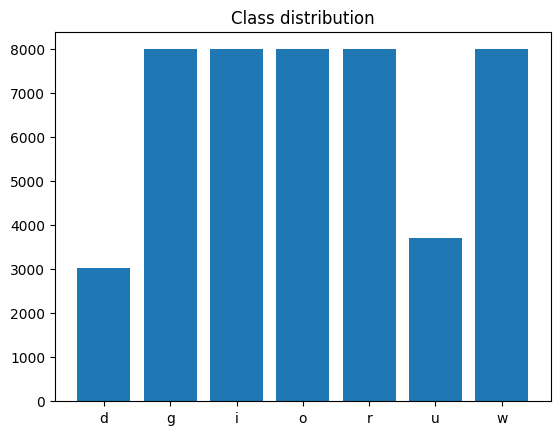

In [17]:
existing_labels: np.ndarray = train_df["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

['d' 'g' 'i' 'o' 'r' 'u' 'w']
[1000 1000 1000 1000 1000 1000 1000]


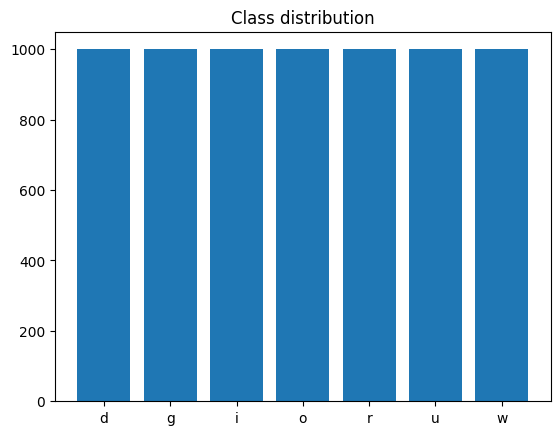

In [18]:
existing_labels: np.ndarray = test_df["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

In [19]:
activities = train_df["Behaviour"].value_counts()
activities

Behaviour
g    8000
o    8000
w    8000
r    8000
i    8000
u    3720
d    3030
Name: count, dtype: int64

In [20]:
def handle_minor_classes(
    data: pd.DataFrame,
    minor_classes: list[str],
    type: str = "remove",
) -> pd.DataFrame:
    type = type.lower()
    if type == "remove":
        for value in minor_classes:
            data = data[data["Behaviour"] != value]
    else:
        data = data.replace(minor_classes, "o")

    return data


train_df = handle_minor_classes(
    data=train_df,
    minor_classes=["u"],
    type="remove",
)
train_df = handle_minor_classes(
    data=train_df,
    minor_classes=["d", "w"],
    type="merge",
)
gc.collect()

test_df = handle_minor_classes(
    data=test_df,
    minor_classes=["u"],
    type="remove",
)
test_df = handle_minor_classes(
    data=test_df,
    minor_classes=["d", "w"],
    type="merge",
)
gc.collect()

print(train_df.shape)
train_df.head()

(43030, 40)


,serial_number,nickname,animalID,sample_rate,timestamps,Behaviour,acc_axis1,acc_axis2,acc_axis3,acc_mag,...,dis_axis1_denoised,dis_axis2_denoised,dis_axis3_denoised,dis_mag_denoised,tilt_axis1,tilt_axis2,tilt_axis3,tilt_axis1_denoised,tilt_axis2_denoised,tilt_axis3_denoised
15000,COW8,COW8,8.0,30.0,2023-04-26 10:04:01.000000,g,-0.781,-0.410,0.477,1.002791,...,-20.197167,19.000719,8.252867,28.932035,-58.109031,-28.526658,76.943668,-55.042199,-31.886839,77.177041
5000,COW3,COW3,3.0,30.0,2023-04-26 10:04:01.000000,g,-0.879,-0.520,0.238,1.048659,...,-17.433738,23.412510,-1.571535,29.232697,-70.853854,-12.153591,75.434447,-66.404004,-16.310934,73.427897
15001,COW8,COW8,8.0,30.0,2023-04-26 10:04:01.033333,g,-0.895,-0.199,0.211,0.940823,...,-20.210059,19.011466,8.257665,28.949462,-58.106904,-28.528888,76.943585,-55.042878,-31.887347,77.179567
5001,COW3,COW3,3.0,30.0,2023-04-26 10:04:01.033333,g,-0.984,-0.426,0.148,1.082421,...,-17.444485,23.425298,-1.571869,29.249366,-70.846786,-12.161047,75.431755,-66.412238,-16.304434,73.432537
5002,COW3,COW3,3.0,30.0,2023-04-26 10:04:01.066666,g,-1.145,-0.148,0.305,1.194133,...,-17.455231,23.438087,-1.572212,29.266036,-70.839592,-12.168592,75.428979,-66.420467,-16.297969,73.437206


In [21]:
# TODO: Drop half the entries of "g".
# dropped_g: pd.Index = train_df[train_df["Behaviour"] == "g"].sample(frac=0.6).index
# train_df = train_df.drop(dropped_g)

# dropped_o: pd.Index = test_df[test_df["Behaviour"] == "o"].sample(frac=0.5).index
# test_df = test_df.drop(dropped_o)

['g' 'i' 'o' 'r']
[ 8000  8000 19030  8000]


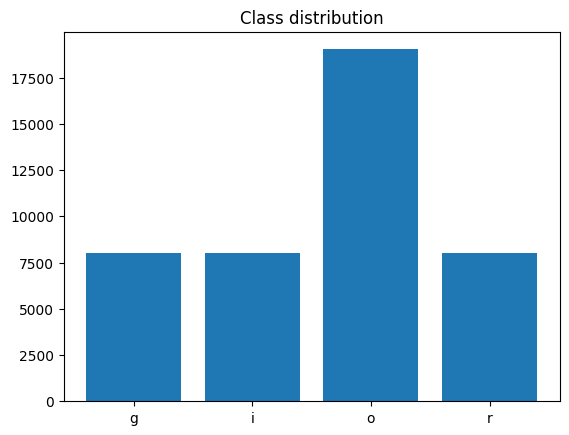

In [22]:
existing_labels: np.ndarray = train_df["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

['g' 'i' 'o' 'r']
[1000 1000 3000 1000]


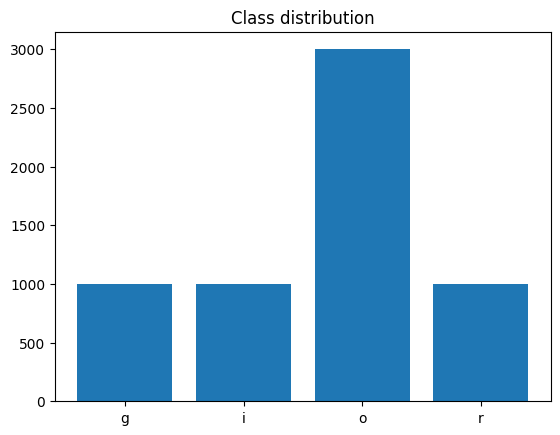

In [23]:
existing_labels: np.ndarray = test_df["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

del existing_labels

In [24]:
label = LabelEncoder()
train_df["label"] = label.fit_transform(train_df["Behaviour"])
# unique_labels: np.ndarray = (
#     train_df.groupby(["Behaviour", "label"])
#     .size()
#     .reset_index()["Behaviour"]
#     .to_numpy()
# )

test_df["label"] = label.fit_transform(test_df["Behaviour"])
# unique_labels: np.ndarray = (
#     test_df.groupby(["Behaviour", "label"]).size().reset_index()["Behaviour"].to_numpy()
# )

unique_labels: np.ndarray = train_df["label"].unique()
unique_labels.sort()

print(unique_labels)
test_df.head()

[0 1 2 3]


,serial_number,nickname,animalID,sample_rate,timestamps,Behaviour,acc_axis1,acc_axis2,acc_axis3,acc_mag,...,dis_axis2_denoised,dis_axis3_denoised,dis_mag_denoised,tilt_axis1,tilt_axis2,tilt_axis3,tilt_axis1_denoised,tilt_axis2_denoised,tilt_axis3_denoised,label
20000,COW11,COW11,11.0,30.0,2023-04-27 08:58:05.000000,g,-0.848,-0.285,-0.008,0.894647,...,15.719846,3.155214,20.400092,-60.685181,-27.745910,81.281225,-65.745454,-22.460991,81.318402,0
20001,COW11,COW11,11.0,30.0,2023-04-27 08:58:05.033333,g,-0.805,-0.285,0.336,0.917685,...,15.727447,3.157452,20.411052,-60.678792,-27.751189,81.277539,-65.747604,-22.458710,81.318401,0
20002,COW11,COW11,11.0,30.0,2023-04-27 08:58:05.066666,g,-0.695,-0.543,0.477,1.002698,...,15.735041,3.159685,20.422006,-60.672680,-27.756216,81.273947,-65.749752,-22.456428,81.318393,0
20003,COW11,COW11,11.0,30.0,2023-04-27 08:58:05.100000,g,-0.652,-0.613,0.305,0.945462,...,15.742633,3.161912,20.432955,-60.666802,-27.761007,81.270380,-65.751899,-22.454144,81.318377,0
20004,COW11,COW11,11.0,30.0,2023-04-27 08:58:05.133333,g,-0.633,-0.582,0.148,0.872535,...,15.750224,3.164134,20.443903,-60.661174,-27.765525,81.266771,-65.754044,-22.451858,81.318354,0


### Standardized data

In [25]:
# columns: list = train_df[[
#     "tilt_axis2_denoised",
#     "tilt_axis1_denoised",
#     "lpf_axis1",
#     "tilt_axis2",
#     "tilt_axis1",
#     "lpf_axis2",
#     "acc_axis1",
#     "acc_axis2",
#     "dis_axis1_denoised",
#     "label",
# ]]
# columns = list(columns.columns)
# columns

columns: list = train_df.columns[6:]

In [26]:
x_train = train_df[columns]
y_train = train_df["label"]
del train_df

x_test = test_df[columns]
y_test = test_df["label"]
del test_df

In [27]:
standardize: bool = True

if standardize:
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
else:
    x_train = x_train.to_numpy()
scaled_X_train = pd.DataFrame(data=x_train, columns=columns)
scaled_X_train["label"] = y_train.values
del x_train
del y_train


if standardize:
    scaler = StandardScaler()
    x_test = scaler.fit_transform(x_test)
else:
    x_test = x_test.to_numpy()
scaled_X_test = pd.DataFrame(data=x_test, columns=columns)
scaled_X_test["label"] = y_test.values
del x_test
del y_test

### Frame Preparation

In [28]:
# Use the differences between rows instead of raw accelerometer data.
# scaled_X_train["x_axis"] = scaled_X_train["x_axis"].diff()
# scaled_X_train["y_axis"] = scaled_X_train["y_axis"].diff()
# scaled_X_train["z_axis"] = scaled_X_train["z_axis"].diff()
# scaled_X_train.replace(np.nan, 0, inplace=True)

# scaled_X_test["x_axis"] = scaled_X_test["x_axis"].diff()
# scaled_X_test["y_axis"] = scaled_X_test["y_axis"].diff()
# scaled_X_test["z_axis"] = scaled_X_test["z_axis"].diff()
# scaled_X_test.replace(np.nan, 0, inplace=True)

In [29]:
for i in scaled_X_train.columns[:-1]:
    print(i)

acc_axis1
acc_axis2
acc_axis3
acc_mag
lpf_axis1
lpf_axis2
lpf_axis3
lpf_mag
hpf_axis1
hpf_axis2
hpf_axis3
hpf_mag
spd_axis1
spd_axis2
spd_axis3
spd_mag
spd_axis1_denoised
spd_axis2_denoised
spd_axis3_denoised
spd_mag_denoised
dis_axis1
dis_axis2
dis_axis3
dis_mag
dis_axis1_denoised
dis_axis2_denoised
dis_axis3_denoised
dis_mag_denoised
tilt_axis1
tilt_axis2
tilt_axis3
tilt_axis1_denoised
tilt_axis2_denoised
tilt_axis3_denoised


### Hyper-parameters

In [30]:
window_size: int = 600  # 300: 10 seconds
window_per_epoch: int = 200
epoch: int = 150
batch_size: int = 64

In [31]:
train_data_coverage: np.ndarray = np.full(
    shape=(scaled_X_train.shape[0]),
    fill_value=False,
    dtype=bool,
)

test_data_coverage: np.ndarray = np.full(
    shape=(scaled_X_test.shape[0]),
    fill_value=False,
    dtype=bool,
)

print(train_data_coverage)
print(test_data_coverage)

[False False False ... False False False]
[False False False ... False False False]


In [32]:
# Expected shape: (windows per epoch, window size, 34)
random.seed(1)


def get_frame(
    df: pd.DataFrame,
    window_size: int,
    window_per_epoch: int,
    coverage_array: np.ndarray,
):
    random_range: int = df.shape[0] - window_size

    windows: list = []
    labels: list = []
    for _ in range(window_per_epoch):
        random_starting_point: int = random.randint(0, random_range)
        window: pd.DataFrame = df.iloc[
            random_starting_point : random_starting_point + window_size
        ]

        windows.append(window.iloc[:, :-1])
        labels.append(window["label"])

        coverage_array[
            random_starting_point : random_starting_point + window_size
        ] = True

    # Bring the segments into a better shape
    windows = np.asarray(windows)  # .reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return windows, labels, coverage_array

In [33]:
# Expected shape: (50, 100, 300, 34)
def get_epoch_frame(
    df: pd.DataFrame,
    window_size: int,
    window_per_epoch: int,
    epoch: int,
):
    random_range: int = df.shape[0] - window_size
    epoch_windows: list = []
    epoch_labels: list = []

    for _ in range(epoch):
        windows: list = []
        labels: list = []
        for _ in range(window_per_epoch):
            random_starting_point: int = random.randint(0, random_range)
            window: pd.DataFrame = df.iloc[
                random_starting_point : random_starting_point + window_size
            ]

            windows.append(window.iloc[:, :-1])
            labels.append(window["label"])

        # Bring the segments into a better shape
        windows = np.asarray(windows)  # .reshape(-1, frame_size, N_FEATURES)
        labels = np.asarray(labels)

        epoch_windows.append(windows)
        epoch_labels.append(labels)

    epoch_windows = np.asarray(epoch_windows)
    epoch_labels = np.asarray(epoch_labels)

    return epoch_windows, epoch_labels

In [34]:
# x_train, y_train = get_epoch_frame(
#     df=scaled_X_train,
#     window_size=window_size,
#     window_per_epoch=100,
#     epoch=50,
# )
# x_test, y_test = get_epoch_frame(
#     df=scaled_X_test,
#     window_size=window_size,
#     window_per_epoch=100,
#     epoch=50,
# )

x_train, y_train, _ = get_frame(
    df=scaled_X_train,
    window_size=window_size,
    window_per_epoch=window_per_epoch,
    coverage_array=train_data_coverage,
)
x_test, y_test, _ = get_frame(
    df=scaled_X_test,
    window_size=window_size,
    window_per_epoch=window_per_epoch,
    coverage_array=test_data_coverage,
)

# del scaled_X_train
# del scaled_X_test

In [35]:
print("x train shape: {}".format(x_train.shape))
print("y train shape: {}".format(y_train.shape))

print("x test shape: {}".format(x_test.shape))
print("y test shape: {}".format(y_test.shape))

x train shape: (200, 600, 34)
y train shape: (200, 600)
x test shape: (200, 600, 34)
y test shape: (200, 600)


In [36]:
unique_l = np.unique(y_train)
print(unique_l)

unique_l = np.unique(y_test)
print(unique_l)

[0 1 2 3]
[0 1 2 3]


### Models

In [37]:
from custom_model import CowModel
from inference import Inference

model: tf.keras.Model = CowModel(output_dim=len(existing_types))

In [38]:
input_demo: tf.Tensor = tf.random.normal((1, 300, 34))
output_demo: tf.Tensor = model(input_demo)
output_demo

<tf.Tensor: shape=(1, 300, 4), dtype=float32, numpy=
array([[[-0.1020666 , -0.03589279,  0.26671475, -0.57470995],
        [-0.6953541 , -0.35526782, -0.09456281, -0.7082809 ],
        [-0.6764715 ,  0.5562436 ,  1.743994  ,  0.6604612 ],
        ...,
        [-0.7586744 , -0.9078692 , -1.4197747 , -1.027956  ],
        [-0.26615512, -0.09790166, -0.7988857 ,  0.699806  ],
        [-0.19313844,  0.02014187, -0.62891734,  0.16222206]]],
      dtype=float32)>

In [39]:
engine: Inference = Inference(
    model=model,
    loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss_metric=tf.keras.metrics.Mean(),
    optimizer=tf.keras.optimizers.Adam(),
    accuracy=tf.keras.metrics.SparseCategoricalAccuracy(),
    batch_size=32,
)

In [40]:
from tqdm.notebook import tqdm

accumulated_metrics: dict[str, list] = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

# Create 2 dictionaries to store the label distributions of 2 datasets.
train_labels_distribution: dict[int, int] = {}
test_labels_distribution: dict[int, int] = {}
for label in unique_labels:
    train_labels_distribution[label] = 0
    test_labels_distribution[label] = 0

for i in tqdm(range(epoch)):
    # Generate frames for training and testing dataset.
    x_train, y_train, train_data_coverage = get_frame(
        df=scaled_X_train,
        window_size=window_size,
        window_per_epoch=window_per_epoch,
        coverage_array=train_data_coverage,
    )
    x_test, y_test, test_data_coverage = get_frame(
        df=scaled_X_test,
        window_size=window_size,
        window_per_epoch=window_per_epoch,
        coverage_array=test_data_coverage,
    )
    gc.collect()

    # Get unique labels of the two training and testing set. Then update the
    # distribution dictionary.
    y_train_labels = np.unique(tf.reshape(y_train, (-1)), return_counts=True)
    y_test_labels = np.unique(tf.reshape(y_test, (-1)), return_counts=True)

    for label, count in zip(y_train_labels[0], y_train_labels[1]):
        train_labels_distribution[label] += count
    for label, count in zip(y_test_labels[0], y_test_labels[1]):
        test_labels_distribution[label] += count

    # Create datasets and use them to train the model. Finally, collect metrics.
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    metrics: dict[str, list] = engine.train_val(
        train_data=train_ds,
        val_data=test_ds,
        epoch=1,
    )
    accumulated_metrics["train_loss"].extend(metrics["train_loss"])
    accumulated_metrics["train_accuracy"].extend(metrics["train_accuracy"])
    accumulated_metrics["val_loss"].extend(metrics["val_loss"])
    accumulated_metrics["val_accuracy"].extend(metrics["val_accuracy"])

  0%|          | 0/150 [00:00<?, ?it/s]

epoch: 0 - train loss: 1.139367938041687 - train acc: 0.5457083582878113 - test loss: 0.7266919016838074 - test acc: 0.6748250126838684
epoch: 0 - train loss: 1.1006323099136353 - train acc: 0.6438249945640564 - test loss: 0.7808236479759216 - test acc: 0.6159083247184753
epoch: 0 - train loss: 0.8003527522087097 - train acc: 0.7140083312988281 - test loss: 0.7051841616630554 - test acc: 0.7125416398048401
epoch: 0 - train loss: 0.8896499872207642 - train acc: 0.7072166800498962 - test loss: 0.6187455058097839 - test acc: 0.7417749762535095
epoch: 0 - train loss: 0.8149120807647705 - train acc: 0.7305916547775269 - test loss: 0.4471658766269684 - test acc: 0.837233304977417
epoch: 0 - train loss: 0.8278695940971375 - train acc: 0.6838750243186951 - test loss: 0.5479673743247986 - test acc: 0.7760166525840759
epoch: 0 - train loss: 0.6342996954917908 - train acc: 0.7196916937828064 - test loss: 0.5814810991287231 - test acc: 0.7275000214576721
epoch: 0 - train loss: 0.6745356917381287 -

{0: 3254206, 1: 3387137, 2: 8079868, 3: 3278789}


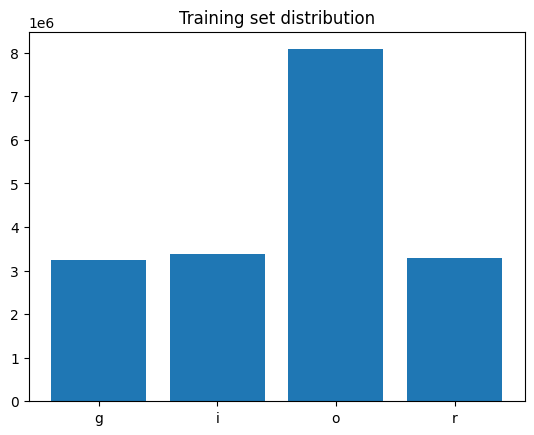

In [41]:
print(train_labels_distribution)
train_selected_labels: list = list(train_labels_distribution.keys())
for l in train_selected_labels:
    train_selected_labels[l] = existing_types[l]
plt.title("Training set distribution")
plt.bar(train_selected_labels, train_labels_distribution.values())
plt.show()

{0: 2353151, 1: 3299215, 2: 9012545, 3: 3335089}


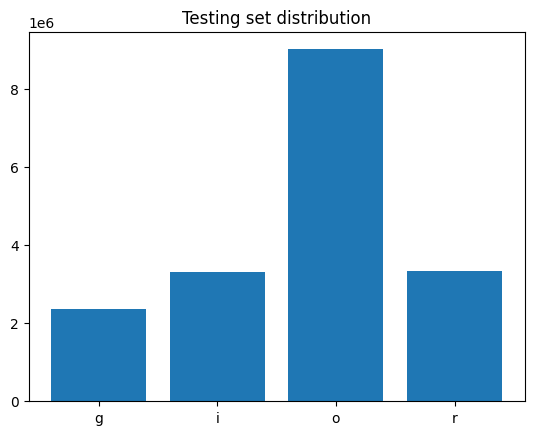

In [42]:
print(test_labels_distribution)
test_selected_labels: list = list(test_labels_distribution.keys())
for l in test_selected_labels:
    test_selected_labels[l] = existing_types[l]
plt.title("Testing set distribution")
plt.bar(test_selected_labels, test_labels_distribution.values())
plt.show()

In [43]:
train_data_switch, train_coverage_count = np.unique(
    train_data_coverage, return_counts=True
)
test_data_switch, test_coverage_count = np.unique(
    test_data_coverage, return_counts=True
)

print(np.asarray((train_data_switch, train_coverage_count)).T)
print(np.asarray((test_data_switch, test_coverage_count)).T)

[[    0     2]
 [    1 43028]]
[[   1 6000]]


In [44]:
test_result: dict = engine.test(test_data=test_ds)

test_result

test loss: 0.594937264919281 - test acc: 0.7736250162124634


{'test_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.59493726>],
 'test_accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.773625>]}

In [45]:
print("training acc: {}".format(accumulated_metrics["train_accuracy"][-1]))
print("training loss: {}".format(accumulated_metrics["train_loss"][-1]))
print("testing acc: {}".format(test_result["test_accuracy"][-1]))
print("testing loss: {}".format(test_result["test_loss"][-1]))

training acc: 0.8599249720573425
training loss: 0.37335240840911865
testing acc: 0.7736250162124634
testing loss: 0.594937264919281


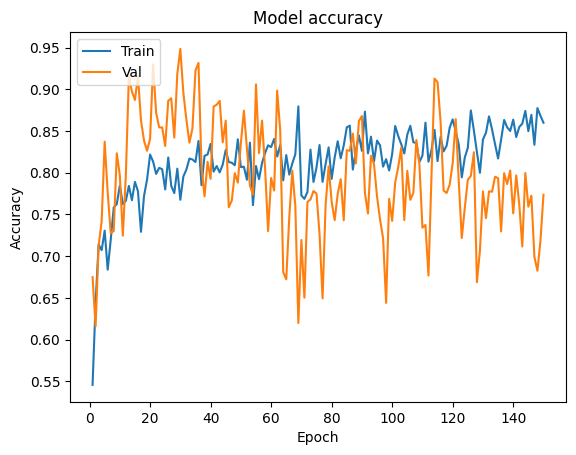

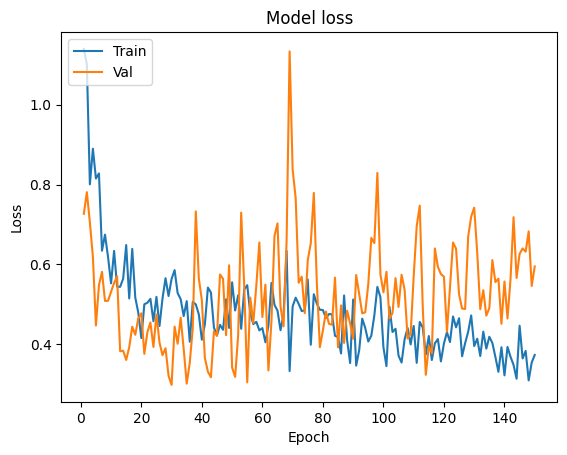

In [46]:
def plot_learningCurve(
    metrics: dict[str, list],
    epochs: int,
):
    # Plot training & validation accuracy values
    epoch_range = range(1, epochs + 1)
    plt.plot(epoch_range, metrics["train_accuracy"])
    plt.plot(epoch_range, metrics["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper left")
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, metrics["train_loss"])
    plt.plot(epoch_range, metrics["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper left")
    plt.show()


plot_learningCurve(
    metrics=accumulated_metrics,
    epochs=epoch,
)

In [47]:
data: list = []
labels: list = []

for datum_batch, label_batch in test_ds:
    data.append(datum_batch)
    labels.append(label_batch)

predict_data: np.ndarray = np.concatenate(data)
predict_labels: np.ndarray = np.concatenate(labels)

In [48]:
y_pred: np.ndarray = model.predict(predict_data)

7/7 [==============================] - 0s 6ms/step


In [49]:
y_test_cm: tf.Tensor = tf.reshape(
    tensor=predict_labels,
    shape=(-1),
)

y_pred_cm: tf.Tensor = (
    tf.math.argmax(
        y_pred,
        axis=2,
        output_type=tf.int64,
    ),
)[0]
y_pred_cm = tf.reshape(
    tensor=y_pred_cm,
    shape=(-1),
)

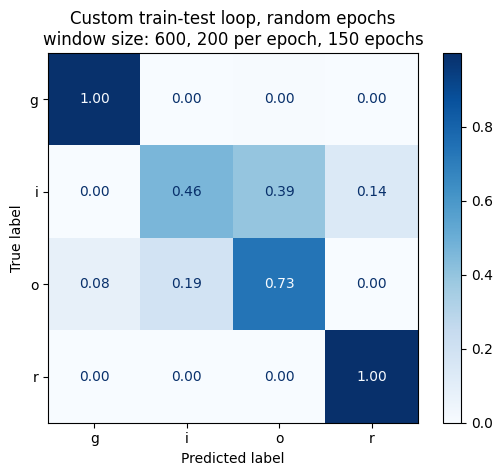

In [50]:
mat = confusion_matrix(
    y_true=y_test_cm,
    y_pred=y_pred_cm,
    labels=unique_labels,
    normalize="true",
)

fig, ax = plt.subplots()
ax.set_title(
    label="Custom train-test loop, random epochs\nwindow size: {}, {} per epoch, {} epochs".format(
        window_size,
        window_per_epoch,
        epoch,
    ),
)
cmd = ConfusionMatrixDisplay(mat, display_labels=existing_types)
cmd.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
# plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [51]:
correct: int = 0
for pred, true in zip(y_pred_cm, y_test_cm):
    if pred == true:
        correct += 1

print(correct / len(y_pred_cm))

0.773625
